<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Nonlinear-finite-element-solver---loopless-implementation" data-toc-modified-id="Nonlinear-finite-element-solver---loopless-implementation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Nonlinear finite element solver - loopless implementation</a></span></li><li><span><a href="#Naming-conventions-for-symbols-and-indexes" data-toc-modified-id="Naming-conventions-for-symbols-and-indexes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Naming conventions for symbols and indexes</a></span></li><li><span><a href="#Running-example" data-toc-modified-id="Running-example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Running example</a></span></li><li><span><a href="#Approximation-of-the-primary-field-variable" data-toc-modified-id="Approximation-of-the-primary-field-variable-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Approximation of the primary field variable</a></span></li><li><span><a href="#Approximation-of-strains" data-toc-modified-id="Approximation-of-strains-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Approximation of strains</a></span></li><li><span><a href="#Nonlinear-iterative-solver" data-toc-modified-id="Nonlinear-iterative-solver-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Nonlinear iterative solver</a></span></li><li><span><a href="#Verification-example" data-toc-modified-id="Verification-example-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Verification example</a></span></li><li><span><a href="#Material-behavior" data-toc-modified-id="Material-behavior-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Material behavior</a></span></li><li><span><a href="#Time-stepping-algorithm" data-toc-modified-id="Time-stepping-algorithm-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Time-stepping algorithm</a></span></li><li><span><a href="#Application-examples" data-toc-modified-id="Application-examples-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Application examples</a></span></li><li><span><a href="#Pullout-response-animation" data-toc-modified-id="Pullout-response-animation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Pullout response animation</a></span></li><li><span><a href="#Alternative-discretization-generator" data-toc-modified-id="Alternative-discretization-generator-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Alternative discretization generator</a></span></li></ul></div>

# Nonlinear finite element solver - loopless implementation
@author: rosoba, Nov 11, 2019

**Numerical model development procedure in a nutshell:**
Development of a numerical model can be described as a process starting from general governing local equations defined in terms of variables (e.g. forces) that are derived from primary unknown variables (e.g. displacement) of the problem at hand. The relation between primary and derived variables must be defined using constraint conditions, e.g. kinematics and constitutive laws. In parallel, the local governing equations (e.g. equilibrium) must be  transfered from to the global structural level. This usually involves integration of the derived variables over the whole structural domain and the inclusion of boundary conditions. At the end of such a model development a continuous boundary value problem is defined that can be solved using numerical methods.

**Goal of this notebook:**
This notebook aims to show how to seamlessly move within the development process from the conceptual, theoretical level of a problem down to short pieces of code that can be directly used to demonstrate and verify the mathematical concept using elementary examples. Working first in a sequential way, proceeding step by step through the imposed assumptions and their mathematical expression we will finally arrive at the level of system equations to be solved.

**No loops, just multiple dimensions and index summation rule:** 
In the model development, an approximation of the primary variables is introduced first following the finite element concept. The derived variables are then also expressed with the help of the selected numerical approximation by following the local equations introduced previously in the continuous, differential formulation. The primary and derived variables are expressed as algebraic combination of shape functions or their derivatives with unknown multipliers. The present notebooks shows how to precalculate all terms related to the known shape functions in a systematic way following the concept of index based notation and Einstein summation rule. This concept is also utilized to implement the numerical integrals of the  governing equations. Multidimensional arrays serving as an integral operators at the domain level can also be precalculated and stored in a large array.

**Time stepping algorithm (with the only two loops in this notebook):** 
After showing the derivation method for the simple case of linear material behavior, we will assume a non-linearity of a constitutive equation and show an iterative scheme to solve the problem, e.g. Newton-Raphson or techniques included in the `scipy` package. Finally, a general loading history will be introduced in combination with an incremental procedure performing the time integration to study a generally nonlinear structural response. During this incremental procedure, the primary and derived state variables are recorded so that they can be processed, visualized and animated.

**How extensible is this kind of implementation?** 
This script demonstrates the index based implementation
of the finite element code for multilayer composite.
The current version demonstrating a uni-axial two-layer
continuum discretized with linear shape functions.
The derived mutltidimensional expressions are general 
and capture multilayer continuum, in 1D, 2D and 3D.

**Import packages**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mathkit.matrix_la.sys_mtx_assembly import SysMtxAssembly
import numpy as np
import sympy as sp
sp.init_printing()

# Naming conventions for symbols and indexes

**Is it going to be an index jungle?**
The usual way of expressing the governing equation is using matrices, i.e. at most a 2D array. In an index-based multi-dimensional implementation, the first impression might be, that's gonna be an index chaos. Admittedly, handling operators on a 10-dimensional array is not usual. To manage such an index complexity, it is necessary to stick to conventions. The single letter convention within a variable name is somewhat limited. However, the benefits are large as we will try to demonstrates. Once the naming conventions have settled in our mind, we are able to formulate a very short, generic code that can be instantiated for different kinds of problems just by changing a model component, i.e. finite element type, kinematic mapping (3D, 2D, plane strain, axi-symmetric), material model, etc. There is almost no performance penalty for the abstract high-level code. Also, data recording and postprocessing can become a real indexing fun. 

**Index groups are associated with specific dimensions:**
Symbols are named using the underscore separation of the name components. Each array name starts with the name of the variable followed by the sequence of letters denoting the indexes of the array dimensions. For example, an array $x_{Eia}$ is named in the code as `x_Eia`. This name indicates, that an array has four dimensions. Further, to simplify orientation the letters used for individual array dimensions are used by following the naming of discretization variables. In particular
   * `EF` is used for global element indexes within a discretization
   * `IJ` is used for global node indexes of a discretization
   * `ij` are used for local node index within an element `E`
   * `mn` is used for a local material point index within an element `E`
   * `abcd` are used for global spatial directions
   * `rs` are the local spatial directions within a discretization element `E`
   * `CD` are used for global index of a continuum layer
   * `op` denote indexes of a global degree of freedom.

Derivatives of a derived $\mathrm{d}u/\mathrm{d}x$ is denoted in the code as `du_dx`.

**Index range within a dimension:**
Given the naming conventions above, the dimensionality of the problem defining the range of indexes $a, b, c, d$ is referred to as $n_a$ in mathematical expressions and as `n_a` in the code. This is a general principle for all index groups specified above, i.e. using `n_X`, where `X` is the first index letter from a group associated with an array dimension. 

**Plotting helper functions:**
To make the diagrams below a bit fancier and to avoid repeated line for label definition and axes description a few helper functions are defined in the following cell which is implicitly hidden. The procedures are not relevant for the discussed issues. However, they are not outsourced to an extra package to make the notebook directly executable. 

In [2]:
def axes_init(ax, xlim, ylim, xlabel, ylabel, title=''):
    '''set the axes limits and labels'''
    ax.cla()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
def plot_filled(ax, x, y, color, alpha):
    '''plot a function and fill the area starting from x-axis'''
    x0 = x[...,0].flatten()
    ax.plot(x0, y, color=color);
    ax.fill_between(x0, y, color=color,alpha=alpha);

*Plot the displacements*:
To plot the displacement at the nodal positions the coordinates $x_{Ei0}$ are used as they are identical with the integration points. The corresponding displacements of the matrix are arranged correspondingly. 

In [3]:
def plot_u_ECm(ax, u_ECi, x_Eia):
    x_Ei0 = x_Eia[...,0].flatten()
    l = ax.plot(x_Ei0, np.einsum('ECi->EiC',u_ECi).reshape(-1, 2));
    l[0].set_color('orange'), l[1].set_color('blue')
    ax.fill_between(x_Ei0, u_ECi[:,0,:].flatten(), u_ECi[:,1,:].flatten(), 
                     color='green', alpha=0.1);
    ax.set_xlabel('$x$ [m]'); ax.set_ylabel('$u$ [m]');
    ax.legend(['m','f']);

*Plot a field variable*: A convenience function accepts the plotting area `ax`, the global displacement vector with the element-wise arranged array of node coordinates `x_Eia` and the mapping from the discrete field indexes $ECi$ and the global degree of freedoms $o$. The expression for a variable to be plotted is supplied as `get_var_ECm` parameter. 

In [4]:
def plot_var_ECm(ax, u_ECi, x_Eia, xi_m, get_var_ECm, ylabel):
    var_ECm = get_var_ECm(u_ECi, x_Eia, xi_m)
    plot_filled(ax, x_Eia, var_ECm[:,0,:].flatten(), color='orange',alpha=0.2);
    plot_filled(ax, x_Eia, var_ECm[:,1,:].flatten(), color='blue', alpha=0.1);
    ax.set_xlabel('$x$'); ax.set_ylabel(ylabel);

# Running example

The concepts will be demonstrated on an example of a pullout model implementation. This example lets us reduce the geometrical dimensionality of the problem to 1 while  keeping the formulation completely general. Moreover, at the end of the notebook we will have a running application that can be used to study the pullout problem from different perspective and to understand the correspondence between the material behavior and structural behavior.

<a id='PulloutProblem'></a>**Figure 1:** Pullout test indicating the scope of boundary value problems addressed in this notebook
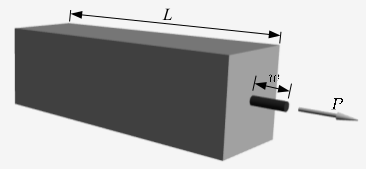

**Geometrical model parameters:** The volume of the simulated specimen will be described using the following parameters

| Symbol            | Variable | Description                                           |
|-------------------|----------|-------------------------------------------------------|
| $L$               | `L_x`    | length of the zone                                    |
| $A_\mathrm{m}$    | `A_m`    | cross sectional area of a matrix layer                |
| $A_\mathrm{f}$    | `A_f`    | cross sectional area of a fiber layer                 |
| $p$               | `p`      | perimeter - contact length between matrix and fiber   |

Let us define the corresponding Python variables as follows 

In [5]:
L_x = 1 # [mm] total length
A_m = 1 # [mm] matrix cross section 
A_f = 1 # [mm] fiber cross section
p = 1 # [mm] bond perimeter

Construct the linear and quadratic terms in every element $E$ and integration point $m$. To use the Einstein summation over the material component cross sections including the sectional area $A_\mathrm{m}$ and $A_\mathrm{F}$ into an array $A_C = [A_\mathrm{f}, A_\mathrm{m}]$

In [6]:
A_C = np.array([A_m, A_f], dtype=np.float_) # cross sectional array

**Dimensionality of the multilayer problem**: For brevity of explanation, we will stick to uniaxial description of the pullout process in this notebook. However, an extension to a planar delamination problem is possible as we will discuss in subsequent notebooks. 

In the following the dimensional indexes $abcd$ might be skipped as we only consider displacement along the pulled direction. However, to include all steps in the derivation let us keep the index through the subsequent derivation steps. It will allow us to describe the Jacobi transformation in a general way and reuse the sheet for 2D model without change.

In [7]:
n_a = 1 # number of dimensions

Our goal is to predict
the response of a pullout specimen in terms of the relation between the pullout force $P$ and displacement $w$. This relation can be easily observed experimentally $P(w)$. To predict this response we need to know what laws of mechanics govern the behavior of every single point within a specimen and how do they interact. To keep things simple, let us consider a one dimensional idealization of the problem.

<a id='1DIdealization'></a>**Figure 2:** 1D idealization of the pullout problem with graphical representation of equilibrium on infinitesimal element
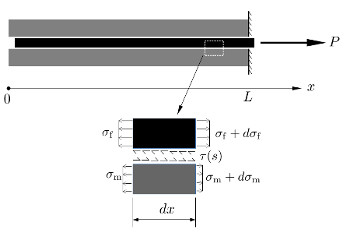

**Equilibrium conditions** of an infinitesimal segment of the reinforcement shown in Fig. [2](#1Didealization) can be expressed as
\begin{equation} \label{eq:f_equi}
 {A_{\mathrm{f}}}\sigma_{\mathrm{f},a} - p \tau(s) = 0,
\end{equation}
where the index $(.)_{,a}$ denotes the derivative w.r.t. the spatial coordinate $x$. The cross-sectional area and the perimeter of the reinforcement  are denoted as $A_{\mathrm{f}}$  and $p$, respectively. Similarly, the equilibrium of the matrix can be expressed as
\begin{equation} \label{eq:m_equi}
 {A_{\mathrm{m}}}\sigma_{\mathrm{m},a} + p \tau(s) = 0,
\end{equation}
where $A_\mathrm{m}$ is the cross-sectional area of the matrix.

**Let's start with the index machinery:** Even though the indexing rule will become really relevant only when deriving the finite element approximation of the problem, let us practice already here by rewriting the above two equations as
<a id="eq_equilibrium"></a>
\begin{align}
 A_C \, \sigma_{C,a} + \zeta_C\, p \tau = 0.
\end{align}
Index $C \in [0,1]$ is defined to distinguish the bar/fiber $\mathrm{f}: C = 0$ pulled out from the matrix $\mathrm{m}: C = 1$. The operator $\zeta_{C} = [-1, 1]$ introduces the sign switch needed to consider the opposite direction of shear flow $p\tau$ w.r.t. fibers or matrix. 
An array with alternating  $\zeta_{C}$ signs can be defined generically using the power function $\zeta_{C} = -(-1)^{C}, C = 0...(n_C)$. Using `numpy` such array operator looks as follows:

In [8]:
n_C = 2 # just two components
zeta_C = -np.power(-1,np.arange(0,n_C))
print(zeta_C)

[-1  1]


**Constitutive law (let's keep it abstract for now):**
Having specified the [equilibrium condition](#eq_equilibrium) we aim to find relations of all involved stress variables to the primary variables, i.e. to the displacement field $u_C$. The first step is to relate stresses $\sigma_C$ to strains $\varepsilon_C$ and bond stress $\tau$ to the slip $s$ between the two material components. 

To keep the code general for a nonlinear material behavior, let us introduce for now only a placeholder of the functional dependency  
\begin{align}
\sigma_C = \mathcal{S}(\varepsilon_C)
\end{align}
for material components and 
\begin{align}
\tau_C = \mathcal{T}(s)
\end{align}
This general assumption allows us to postpone some concrete choice to the later stage of derivation. For now, it is enough to have the symbols $\varepsilon_C$ and $s$ introduced in the equilibrium conditions.

**Kinematics:**
In 3D continuum, strain variables are related to the component displacements using the two relations
\begin{align}
 \varepsilon_{Cab} = \frac{1}{2} ( u_{Ca,b} + u_{Cb,a} ).
\end{align}

In the considered uniaxial case this transforms to 
<a id="eq_varepsilon_{Caa}"></a>
\begin{align}
\varepsilon_\mathrm{C} = u_{C,a}.
\end{align}

The slip between the components is defined as
\begin{align}
  s = u_{\mathrm{f}} - u_{\mathrm{m}} = \zeta_C u_{C}
\end{align}

**Differential equilibrium equation**
<a id="eq_differential_equilibrium_equation"></a>
At this stage, we have managed to relate the [governing equilibrium equations](#eq_equilibrium) to the primary variable of the problem, i.e. we can write
\begin{align}
  A_C \mathcal{S}_{C,a}( u_{C,a} ) + \zeta_C \, p \mathcal{T}( \zeta_D u_D ) = 0
\end{align}

Herewith we have ensured ourselves that the link from the differential governing equation to the primary variable is possible to resolve algebraically once the material behavior $\mathcal{S}(\varepsilon)$ and $\mathcal{T}(s)$ has been specified, let us try mathematically formulate the requirement that these equations must be fulfilled in the whole domain of the specimen. More precisely, along the idealized bond zone $x \in (0,L)$ of the idealized pullout specimen shown in [Fig 2](#1DIdealization).

**Boundary conditions:**
The first step in this direction is to define the essential and natural boundary conditions 
\begin{align}
u_C 
&= 
\bar{u}_C(\theta) \;\; \mathrm{on} \;\; \Gamma_{u_C},  
&
\sigma_C A_C &= \bar{t}_C(\theta) \;\; 
\mathrm{on} \;\;
\Gamma_{t_C}.
\end{align}
in which $\Gamma_{u_C}$ and $\Gamma_{t_C}$ denote the boundary points where the corresponding boundary conditions are applied. The essential boundary conditions $\bar{u}_C$ and the natural boundary 
conditions $\bar{t}_C$ are prescribed as functions of the intrinsic time variable $\theta$ which is used to control the loading history. 

<a id="eq_weak_equilibrium"></a>
**Weak form of equilibrium and boundary conditions:**
Denoting the integration of the product of two functions $u$, $v$ over the domain $V$ as $\left( u , v \right)_V$, the weak formulation can be expressed as 

\begin{align}
\left( \delta u_C, A_C \sigma_{C,a} + \zeta_C p \tau \right)_\Omega + 
\left( \delta u_C, -A_C \sigma_{C} + \bar{t}_C(\theta) \right)_{\Gamma_{t_C}} +
\left( \delta u_C, u_C - \bar{u}_C(\theta) \right)_{\Gamma_{u_C}} = 0.
\end{align}
With this equation we have transformed the requirement of a [differential equilibrium](#eq_equilibrium) to the requirement that the product between an arbitrary functions $\delta u_C$ with equilibrium condition must be zero. In fact, the so called test functions $\delta u_C$ cannot be completely arbitrary, they must 
have continuous first derivatives, and be $L^2$ integrable and implicitly fulfill the essential boundary conditions, i.e.
$\delta u_C=0$ on $\Gamma_{u_C} $. As a consequence, the last term in the weak equilibrium condition vanishes.

**Integration by parts:** 
It is convenient to get rid of the stress derivatives w.r.t. $x$ in [weak equilibrium](#eq_weak_equilibium) using the integration by parts to obtain
in the above integration can be reduced as follows

\begin{align}
\left( \delta u_C, A_C \sigma_{C,a} \right)_{\Omega}
&=
\left( \delta u_C, A_C \sigma_C \right)_\Gamma -
\left( \delta u_{C,a}, A_{C} \sigma_{C} \right)_\Omega
\end{align}


<a id="eq_reduced_weak_form"></a>
**Reduced weak form:**
Using this formula, the following variational formulation of a debonding problem is obtained

\begin{align}
 A_C \, \left(\delta u_{C,a}, \sigma_{C}\right)_\Omega + 
 p \, \left(\delta u_C, \zeta_C \tau \right)_\Omega -
\left( \delta u_C, \bar{t}_C(\theta) \right)_{\Gamma_{t_C}} 
= 0.
\end{align} 

**What is it good for?:** 
Albeit one-dimensional, this equation provides quite some potential for efficient calculation of practical problems in composites, like pull-out, push-in or crack bridge configurations as we shall show later on. The intention to keep the code general leads to some decisions related to the coding style.

**Python note on configurability and parameterization**: To make the expressions derived in the notebook generally useful for several applications, some expressions are not evaluated directly in the command line but are defined as functions with parameters that can be specified only later. Two forms of function definition are used (To get a basic understanding of function definition in Python see e.g. the Tutorial section on functions [here](https://docs.python.org/3/tutorial/controlflow.html#defining-functions)):
  - `lambda` functions are used to define a callable function on the fly inline
  - `def` functions are used for more complex expressions

Names of functions representing derived expressions start all with `get_`. 
The parameterization of expressions we will related only to variables that change with a discretization or with a material behavior (e.g. number of finite elements $n_E$, material stiffness, maximum load, etc.). As we want to show on examples this parameterization allows us to show several application examples at the end of the notebook. Configurational parameters, e.g. the dimensionality of the problem $n_a$, number of composite layers $n_C$, number of element nodes $n_i$ are assumed constant within a notebook. They are there to prepare an adoption of the whole notebook for 2D or 3D configurations. 

To proceed further with the model development we have to abondon the continuity of the primary and derived field variables and start with approximate solution. The procedure is now a kind of **backward substitution**. Once we define an approximation of the displacement field $u_C$ and of the test functions $\delta u_C$ we can simply substitute them into the above defined kinematic conditions and into the [reduced weak form](#eq_reduced_weak_form).

# Approximation of the primary field variable

The primary field variable used generally in 3D domain is the displacement $u_a(x_b)$. However, as only a uni-axial pullout problem is considered here $n_a=1$ we will skip the dimensional indexes $a$ and $b$. This section shows a step by step derivation of the shape functions, Jacobi transformation and expressions needed to construct the system matrix.

Bar discretized consisting of two components, i.e. matrix $\mathrm{m}$ and fiber $\mathrm{f}$. The domain is discretized using nodes $I \in (1,n_I)$

<a id="Discretization">Figure 3: Discretization</a>
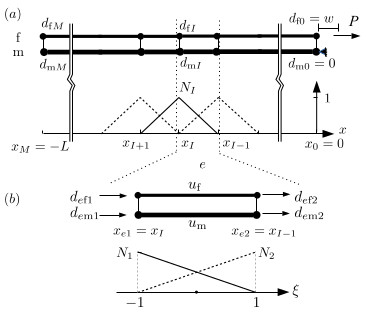

**Globally defined shape functions:** Tha approximation of the displacement field of a component $C \in [\mathrm{m}, \mathrm{f}]$ (matrix or fiber) needed to resolve the strains and stresses in. [differential equilibrium](#eq_differential_equilibrium_equation) is introduced as
\begin{align}
 u_{C}(x) = N_I(x) \, u_{CI}
\end{align}
This approximation is depicted in Fig. [3a](#Discretization). Following the concept of the finite-element approximation, the test functions needed in the [reduced weak form](#eq_reduced_weak_form) are approximated using the same shape functions
\begin{align}
 \delta u_{C}(x) = N_I(x) \, \delta u_{CI}
\end{align}

**Element-wise defined shape functions:** As shown in Figure [1a](#Figure-1:-Discretization), finite element shape functions have value 1 in the node $I$ and zero in all other nodes. Thus, in numerical implementations of spatial integrals over the domain, it is only necessary to consider the region of a shape function with nonzero values, i.e. $N_I(x_b) \neq 0$. Let us therefore introduce the local domain within a discretization element $E$ covered by the parametric coordinates $\xi_r \in (-1, 1)$. With shape functions $N_i(\xi_r)$ defined within an element in terms of $\xi$ only nodes $i$ of an element $E$ need to be considered.
So that the global approximation can be rewritten for each element $E$ as
\begin{align}
 u_{CEa}(\xi_r) = N_{Ei}( \xi_r ) \, u_{CEia}, \;\;\;
 \delta u_{CEa}(\xi_r) = N_{Ei}( \xi_r ) \, \delta u_{CEia}
\end{align}

As a consequence of this choice, the shape functions of all elements $E$ are the same so that their index can be skipped, i.e. 
\begin{align}
 u_{CEa}(\xi_r) = N_{i}( \xi_r ) \, u_{CEia}, \;\;\;
 \delta u_{CEa}(\xi_r) = N_{i}( \xi_r ) \, \delta u_{CEia}
\end{align}

**Python note on symbolic expressions:** The intention of this notebook is not only to implement a particular model for pullout problem but to provide a general template for construction of similar numerical models. It is therefore convenient to express the shape functions in symbolic form. Using this approach, the machinery of finite element derivation can be completely automated. To introduce the symbolic definition of $N_(\xi)$, the `sympy` package can be conveniently used. In the preamble, this package has been imported as `import sympy as sp`. A brief introduction to the `sympy` package that can help to understand the following few lines of code is provided e.g. [here](https://docs.sympy.org/latest/tutorial/intro.html)

Let us first define the parametric coordinate $\xi \in (-1,1)$ interpolating within the domain between the finite element nodes $\xi_0 = -1$ and $\xi_1 = 1$: (The trailing underscore is used to distinguish symbolic expressions from normal Python variables.) 

In [9]:
xi_ = sp.symbols('xi')

Following the convention defined above, the local node index is denoted as $i$ so that we can write
\begin{align}
\xi_i = [-1, 1]
\end{align}

In the present example, linear shape functions are considered: 
\begin{align}
 N_0 & = (1-\xi)/2, \; N_1 =(1+\xi)/2 \\
 N_i(\xi) &= [ N_0(\xi), N_1(\xi) ] \nonumber
\end{align}

**Python note:** The symbolic `sympy` code uses the object `Rational` to treat also the numbers symbolicaly. Otherwise, `1/2` would be directly resolved to a float `0.5`

In [10]:
N_i_xi_ = sp.Rational(1/2)*sp.Matrix([[(1 - xi_) , (1 + xi_)]])
N_i_xi_

**Remark: Verification of partition of unity condition:**
Let us verify that the condition needed to reproduce the rigid body motion and constant strain state is fulfilled. The shape function must sum up to unity at every point of the domain as
\begin{align}
  \delta_{ii} N_{i}( \xi_i ) = 1 
\end{align}
For linear functions introduced above, this can be easily verified manually. Using `sympy` we can perform the summation symbolically to obtain

In [11]:
N_i_xi_[0] + N_i_xi_[1]

Now, let us transform the symbolic representation of the shape functions into an executable code that accepts not only a single value of $\xi$ but a multi-dimensional array that can be evaluated in a single call. Such a transformation requires the `sympy` methods called `lambdify`. The new callable variable `get_N_i_xi` represents a function that accepts an array of parametric coordinates.

In [12]:
lambda_N_i_xi = sp.lambdify(xi_, N_i_xi_, 'numpy' )
get_N_i_xi = lambda xi: lambda_N_i_xi(xi)[0,...] # drop the first dimension from lambdify

For later manipulations with the discretization into a form of multidimensional arrays let us introduce the size of element nodes $n_{Ei}$ and size of elemental degrees of freedom $n_{Eo}$. 

In [13]:
n_Ei = n_C * len(N_i_xi_) # number of element nodes
n_Eo = n_Ei * n_a # number of elemental degrees of freedom

**Example: shape functions evaluated in nodal points**
To verify the function `get_N_i_xi( xi )` let us evaluate its values $N_i(-1)$, $N_i(1)$ and $N_i(0)$:

In [14]:
print(get_N_i_xi(np.array([-1,0,1])))

[[1.  0.5 0. ]
 [0.  0.5 1. ]]


Note the first index of the return array is the local node index $i$. Further dimensions correspond to the input array.

# Approximation of strains

Using the approximated displacement field the [component strains](#eq_varepsilon_{Caa}) are approximated as
\begin{align}
\varepsilon_{ECaa} &= N_{i,a}(\xi_r) \, u_{ECia}
\end{align}
The term $N_{i,a}(\xi_r)$ represents the derivative of the shape function w.r.t. the global coordinate $x_a$. However, the shape functions are only available in the parametric coordinates, i.e. $N_i(\xi_r)$. Assuming that we can somehow relate the local coordinates $\xi_r$ to the global ones $x_a$ let us apply the chain rule
\begin{align}
N_{i,a}(\xi_r) &= N_{i,r} \, \xi_{r,a}
\end{align}

The derivatives $N_{i,r}$ of the shape functions are obtained easily using the sympy automatic differentiation invoked as `diff` method on the matrix of shape functions 

In [15]:
dN_xi_ri_ = N_i_xi_.diff('xi')
dN_xi_ri_

In [16]:
get_dN_xi_ir = sp.lambdify(xi_, dN_xi_ri_.T, 'numpy')

**Example: evaluate derivatives for a set of local integration points**

In [17]:
dN_xi_mir = get_dN_xi_ir(np.array([[-1,1],[0,1]], dtype=np.float_ ))
print(dN_xi_mir)

[[-0.5]
 [ 0.5]]


Note that the dimension of the input array $\xi_m$ is ignored. This is the consequence of the fact that the derivatives are constant within an element. Therefore, the `diff` operation drops the variable $\xi$ from the evaluation and the `lambdify` function ignores the dimension of the input array. The shape of the output array is identical with that of the input array, namely $ir$. 

**Geometry approximation:**
An isoparametric approximation of the geometry and of the displacement is going to be used next. Thus, to obtain the global coordinates of a point within a finite element $E$ we can write
\begin{align}
 x_{Ea} = N_i( \xi_r ) \, x_{Eia}
\end{align}
Note that the layer index $C$ is omitted here. The same shape functions are used for both layers within the domain.
By applying the chain rule, can now write the derivative $x_{a,r}$ as
\begin{align}
 x_{Ea,r} = N_{i,r}\, x_{Eia} =  J_{Era}
\end{align}
Let us define an operator calculating the Jacobi matrix as

In [18]:
get_J_Era = lambda x_Eia, xi: np.einsum('ir,Eia->Era', get_dN_xi_ir(xi), x_Eia)
get_J_mEra = lambda x_Eia, xi_m: get_J_Era(x_Eia, xi_m)[np.newaxis,...]

**Example: Evaluate the Jacobi matrix**
Given an array of nodal coordinates and of parametric coordinates $\xi_\mathrm{m}$ evaluate the Jacobi matrix using the function `get_J_mEra`

In [19]:
J_mEra = get_J_mEra( np.array([[[1],[2]],[[2],[3]]]), np.array([-1, 0, 1]) )
print(J_mEra)

[[[[0.5]]

  [[0.5]]]]


However, to get the global derivative of $N_{i,a}$ we need 
the inverse mapping, i.e. not $x_{Ea,r}$ but $\xi_{Er,a}$. This can be obtained
by inverting the Jacobi matrix
\begin{align}
 \xi_{Er,a} = J^{-1}_{Era}
\end{align}
The corresponding function can be written as follows 

In [20]:
get_inv_J_mEra = lambda x_Eia, xi: np.linalg.inv(get_J_mEra(x_Eia, xi))

The global derivatives of shape functions needed for evaluation of derived field variables are thus obtained as
\begin{align}
 N_{Ei,a} = N_{i,r} J^{-1}_{Era}
\end{align}

In [21]:
get_dN_x_mEia = lambda x_Eia, xi: np.einsum(
    'ir,mEra->mEia', get_dN_xi_ir(xi), get_inv_J_mEra(x_Eia,xi))

**Remark: Irregular discretization structure:**
Note that unlike the function $N_{i,r}$ which is identical for all elements, the derivatives are generally different for each element. If all elements have the same shape and same size, the terms $N_{Ei,a}$ would be the same and the index $E$ might be dropped in the further expressions.

**Example: Jacobi matrix and derivatives on a single element**: Consider an element with the nodal coordinates $x_{i} = [0,2]$. The global derivatives of the shape functions at position $\xi_m = [0]$ are obtained as follows:

In [22]:
x_Eia = np.array([[[-1], [1]]], dtype=np.float_)
get_dN_x_mEia(x_Eia, [0])

array([[[[-0.5],
         [ 0.5]]]])

**Strains:** Finally, recalling again the index notation 
\begin{align}
\varepsilon_{ECmab} = N_{Eim,a} u_{ECib}
\end{align}
we may write the function delivering strains for the supplied nodal displacements as

In [23]:
get_eps_ECm = lambda u_ECi, x_Eia, xi_m: np.einsum(
    'm,nEia,ECi->ECm', np.ones(len(xi_m)),get_dN_x_mEia(x_Eia,xi_m), u_ECi
)

**Todo:** explain the dimensional expansion for the material points

**Example:** Evaluate the strain for a bar with the length of 2 m with left node displacement $u_{0,0,0} = 0$ and right node displacement $u_{0,0,1} = 1$. The corresponding nodal coordinates are defined as $x_{0,0} = 0$ and $x_{0,1} = 2$ 

In [24]:
get_eps_ECm(np.array([[[0,1]]]), np.array([[[0],[2]]]), [0])

array([[[0.5]]])

**Slip:** The difference between matrix and fiber displacement $\mathrm{m}$ and $\mathrm{f}$, respectively, is obtained by evaluating
\begin{align}
s_{Em} = \zeta_{C} N_{mi} u_{ECi}
\end{align}

In [25]:
get_s_Em = lambda u_ECi, xi_m: np.einsum(
    'C,im,ECi->Em', zeta_C, get_N_im(xi_m), u_ECi
) 

# Nonlinear iterative solver

<a id="eq:variational_form_m"></a>
As already mentioned, the test functions introduced in the [weak form](#eq_reduced_weak_form) use the same approximation as the displacements. Therefore, we can approach to further specification of the global governing equations. By substituting for the shape functions we obtain

\begin{align}
\delta u_{ECi} \left(N_{Ei,x}, A_C \sigma_C \right)_\Omega +
\delta u_{ECi} \left( \zeta_C N_{i} , p\tau \right)_\Omega -
\delta u_{ECi} \left( N_{i}, \bar{t}_{c}(\theta) \right)_{\Gamma_{t_{C}}} = 0.
\end{align}

**Assembly operator:** Since we require that these equations must be fulfilled for arbitrary values of test functions $u_{C}$, we implicitly say that this must hold also for their approximations. As the shape functions $N_i$ are fixed, the arbitrariness now relates only to the multipliers, i.e. to the nodal values of the test function approximation. But can we directly take the multipliers of the element-wise approximation $\delta_{ECi}$? Not really! Multipliers, i.e. degrees of freedom are shared by two elements so that several equilibrium conditions would be associated with a single degree of freedom. Thus, to proceed we need to link them using an index mapping.
\begin{align}
o_{ECi} := (E,C, i) \rightarrow O
\end{align}
where $O$ is the global unique index of the degree of freedom. Using this index map we can define an assembly operator as
\begin{align}
\mathcal{A}_{o}\left(B_{ECi}\right) &:= 
A_{O}[O_{ECi}] = A_{O}[O_{ECi}] + B_{ECi}, \forall (E,C,i)
\end{align}

**Python note:** This kind of element-wise assembly of forces and stiffness is usually done by looping over elements and adding the contributions to the appropriate positions of the global vector. As we like to avoid loops in this implementation, we can conveniently using a `numpy.bincount` method.

In [26]:
B_ECi = np.array([[[1,2]],[[3,4]]])
O_ECi = np.array([[[0,1]],[[1,2]]])
np.bincount(O_ECi.flatten(), weights=B_ECi.flatten())

array([1., 5., 4.])

Each occurrence of index 1 has been weighted by the respective terms in the `B_ECi` array yielding the value 5 at the index 1 of the resulting vector (note that the first position has an index 0).   

Using this assembly operator we can rewrite the residuum in terms of unique degrees of freedom as
\begin{align}
\delta U_O R^{(\theta)}_{O} &= 
\delta U_O \left[ \mathcal{A}_O\left(N_{Ei,x}, A_C \sigma_C \right)_\Omega + 
\mathcal{A}_O\left( \zeta_C N_{i} , p\tau \right)_\Omega -
\mathcal{A}_O\left( N_{i}, \bar{t}_{c}(\theta)
\right)_{\Gamma_{t_{C}}}  \right] = 
0.
\end{align}

<a id="eq_equilibrium_residuum"></a>
In this form, the arbitrariness is related to unique global degrees of freedom, i.e. $\delta U_o$. Now the term in the brackets represents an equation system to be solved for $u_C$ approximation.
\begin{align}
R^{(\theta)}_{O} = 
\mathcal{A}_O\left(A_C N_{Ei,x}, \sigma_C \right)_\Omega + 
\mathcal{A}_O\left(p \zeta_C N_{i}, \tau \right)_\Omega -
\mathcal{A}_O\left(N_{i}, \bar{t}_{c}(\theta)
\right)_{\Gamma_{t_{C}}}  &= 0.
\end{align}

The first two terms represent the internal forces $F_O$ and the third term $\bar{F}_{Eo}$ denotes the external force. In the sequel only nodal external forces $\delta(x_Ei) \bar{t}$ will be considered so that the integral term will dropped in the sequel. Thus we can rewrite the  residuum as a requirement on equilibrium in all global DOFs $O$.
\begin{align}
R_O^{(\theta)}(U_{P}) = F_{O}(U_{P})  - \bar{F}^{(\theta)}_O &= 0.
\end{align}

The obtained set of nodal equilibrium equations can be nonlinear depending on the chosen type of material behavior. Therefore, let us prepare a iteration scheme to find an equilibrium by linearizing the residuum first 
\begin{align}
R^{(\theta)}_{O}(U_{P}^{(k)})
\approx
R^{(\theta)}_{O}(U_{P}^{(k-1)})
+
\left.
\frac{ \partial R^{(\theta)}_{O} }{\partial U_{P}}
\right|_{U_{P}^{(k-1)}}
\Delta U_{P}^{(k)} = 0.
\end{align}

With distinguished internal and external forces, this translates to 
\begin{align}
R^{(\theta)}_{O}(U_{P}^{(k)})
\approx
F_{O}(U_{P}^{(k-1)}) -
\bar{F}^{(\theta)}_{O}
+
\left.
\frac{ \partial F^{(\theta)}_{O} }{\partial U_{P}}
\right|_{U_{P}^{(k-1)}}
\Delta U_{P}^{(k)} = 0.
\end{align}

The derivative of the internal forces with respect to global displacements read

\begin{align}
\frac{ \partial F^{(\theta)}_{O} }{\partial U_{P}}
&=
\mathcal{A}_{OP} \left(N_{Ei,x}, A_D 
\frac{\partial \sigma_D}{\partial U_{P}} 
\right)_\Omega + 
\mathcal{A}_{OP} \left( \zeta_C N_{i} , p
\frac{\partial \tau}{\partial U_{p}}  
\right)_\Omega
\end{align}

Using the chain rule we can proceed by resolving the stress derivatives of the components as follows
\begin{align}
\frac{\partial \sigma_D}{\partial U_P} =
\frac{\partial \sigma_D}{\partial \varepsilon_{D}}
\frac{\partial \varepsilon_{D}}{\partial u_{EDj}}
\frac{\partial u_{EDj}}{\partial U_P} =
\frac{\partial \sigma_{EDm}}{\partial \varepsilon_{EDm}}
N_{Ej,x} [P_{EDj}]
\end{align}

The shear stress derivatives are resolved as follows
\begin{align}
\frac{\partial \tau }{\partial U_P}
 &=
\frac{\partial \tau }{\partial s } 
\frac{\partial s }{\partial u_{EDj} } 
\frac{\partial u_{EDj} }{\partial U_{P} } =
\frac{\partial \tau_{Em} }{\partial s_{Em} } 
\zeta_{D} N_{Ej}
[P_{EDj}]
\end{align}

Note that the derivatives $\partial u_{EDj}/ \partial U_P$ render the index map from the elementwise enumeration of the degrees of freedom to the global ones, i.e. $(E,D,j) \rightarrow P$. Thus, we can extend the mapping operator $\mathcal{A}_{OP}$  to acccount for the assembly of the tangent matrix $K_{OP}$ by introducing the mapping 
\begin{align}
(E,C,i,D,j) \rightarrow (O,P)
\end{align}

<a id="eq_system_matrix"></a>
Thus, the derivative of the residuum representing the system matrix can be finally written as

\begin{align}
K^{(\theta)}_{OP} =\frac{ \partial F^{(\theta)}_{O} }{\partial U_{P}}
&=
\mathcal{A}_{OP} 
\left(A_D N_{Ei,x} N_{Ej,x}, 
\frac{\partial \sigma_{D}}{\partial \varepsilon_{D}}
\right)_\Omega
+ 
\mathcal{A}_{OP} 
\left(  p \, \zeta_C \zeta_{D} \, N_{i} N_{j},
\frac{\partial \tau }{\partial s } 
\right)_\Omega
\end{align}

<a id="eq_recurrence_relation"></a>
**Recurrence relation:** The linearized problem can now be transfered to a recurrent scheme converging quadratically to the solution
\begin{align}
K^{(\theta,k-1)}_{OP} \Delta U_P^{(k)} = \bar{F}^{(\theta)}_O - F_{O}(U_{P}^{(k-1)})
\end{align}

To evaluate this expression we still need to address two issues:  numerical integration represented by the operator $(\ldots)_{\Omega_E}$ and the constitutive laws of components and of the bond  

**Numerical integration scheme**:
To integrate a function over a domain of an element we need to approximate the integral
\begin{align}
  F = \int_{}^{} f( x ) \; \mathrm{d}x
\end{align}
However, the function $f$ is not explicitly available in global coordinates $x$ but in parametric coordinates $\xi$. Therefore, we need the mapping between $\mathrm{d}x$ and $\mathrm{d}\xi$, i.e.
\begin{align}
\mathrm{d}x_a &= \left| \frac{\mathrm{d}x_a}{\mathrm{d}\xi_r} \right| \mathrm{d}\xi_r
= | J(\xi_r ) | \; \mathrm{d}\xi_r
\end{align}
\begin{align}
F = \int_{-1}^{1} f( \xi) \; \frac{\mathrm{d}x}{\mathrm{d}\xi} \; \mathrm{d}  \xi
= \int_{-1}^{1} f( \xi) \; | J(\xi) | \; \mathrm{d}  \xi
\end{align}
Using the quadrature rule with sampling points $\xi_m$ and weight factors $w_m$ integration can be written as
\begin{align}
  F = w_m f( \xi_m ) | J(\xi_m) |.
\end{align}

In [27]:
get_N_im = lambda xi_m: get_N_i_xi(xi_m)

In [28]:
get_J_det_mE = lambda x_Eia, xi_m: np.linalg.det(get_J_mEra(x_Eia, xi_m))

To prepare the recurrent iteration let us collect the terms within the integration that remain constant. They can be precalculated in advance. These multidimensional arrays can be calculated only once at the beginning. They represent linear and quadratic forms of  shape functions and of their derivatives. The order of derivative will be denoted by the superindex $^{(0)}$ und $^{(1)}$. Thus, four cached integration array operators will be constructed: $\mathcal{B}^{(1)}_{ECmi}$, $\mathcal{B}^{(0)}_{ECmi}$, $\mathcal{Q}^{(1)}_{ECmi}$ and $\mathcal{Q}^{(0)}_{ECmi}$.

**Caching of global integration operators:** The individual collected terms are now defined as functions of the array of global coordinates $x_{Eia}$ and of the integration scheme defined by $\xi_m$ and $w_m$. The operator for global kinematic mapping associated with the strain in the material components reads

\begin{align}
\mathcal{B}^{(1)}_{EmCid} &=
w_m \delta_{CD} A_{C} N_{Ejm,d} | J |_{Em}
\end{align}

In [29]:
get_B1_EmCia = lambda x_Eia, xi_m, w_m: np.einsum(
    'm,C,mEia,mE->EmCia', 
    w_m, A_C, get_dN_x_mEia(x_Eia,xi_m), get_J_det_mE(x_Eia,xi_m)
)

The operator for global mapping of integration over the bond stress is defined as
\begin{align}
\mathcal{B}^{(0)}_{EmCi} &=
w_m \zeta_{CD} p N_{Ejm} | J |_{Em}
\end{align}

In [30]:
get_B0_EmCi = lambda x_Eia, xi_m, w_m: np.einsum(
    'm,C,im,mE->EmCi', 
    w_m, zeta_C, get_N_im(xi_m), get_J_det_mE(x_Eia,xi_m)
) * p

The integral operator associated with the component contributions to the system matrix is an 8-dimensional field defined as
\begin{align}
\mathcal{Q}^1_{EmCiaDjb} = w_m \delta_{CD} A_{C} N_{Eim,c} N_{Ejm,d} | J |_{Em}
\end{align}

In [31]:
DELTA_CD = np.identity(n_C)
get_Q1_EmCiaDjb = lambda x_Eia, xi_m, w_m: np.einsum(
    'm,CD,C,mEia,mEjb,mE->EmCiaDjb',
    w_m, DELTA_CD, A_C, get_dN_x_mEia(x_Eia,xi_m), get_dN_x_mEia(x_Eia,xi_m), 
    get_J_det_mE(x_Eia,xi_m)
)

The operator with the coefficients needed to integrate the contributions of the bond stiffness to the system matrix is given as
\begin{align}
\mathcal{Q}^0_{EmCiDj} = w_m \zeta_{CD} p N_{Eim} N_{Ejm} | J |_{Em}.
\end{align}

In [32]:
ZETA_CD = np.einsum('C,D->CD', zeta_C, zeta_C)
get_Q0_EmCiDj = lambda x_Eia, xi_m, w_m: np.einsum(
    'm,CD,im,jm,mE->EmCiDj',
    w_m, ZETA_CD, get_N_im(xi_m), get_N_im(xi_m), get_J_det_mE(x_Eia,xi_m)
) * p

The numerical quadrature of the [internal forces](#eq_equilibrium_residuum) with constant terms collected in the braces can be written as
\begin{align}
F_{O} 
&= 
\mathcal{A}_O\left[\mathcal{B}^{(1)}_{ECmi} \, \sigma_{Cm} \right] + 
\mathcal{A}_O\left[\mathcal{B}^{(0)}_{ECmi} \, \tau_m \right]  
= \mathcal{A}_O\left[ F_{Eo} \right] 
\end{align}

where 
\begin{align}
F_{Eop} &= \mathcal{B}^{(1)}_{ECmi} \sigma_{Cm} + \mathcal{B}^{(0)}_{ECmi} \tau_{m}  
\end{align} 
collects the first two terms with element contributions to the internal forces corresponding to the element DOFS $(E,o)$. 

In [33]:
def get_F_Eo(B1_EmCia, B0_EmCi, sig_ECm, tau_Em):
    # Elementwise evaluation of internal forces and stiffness matrix
    F_sig_ECi = np.einsum('EmCid,ECm->ECi', B1_EmCia, sig_ECm)
    F_tau_ECi = np.einsum('EmCi,Em->ECi', B0_EmCi, tau_Em)
    return (F_tau_ECi + F_sig_ECi).reshape(-1,n_Eo)

Similarly, the integration and collextion of the [system matrix](#eq_system_matrix) is performed analogically 
\begin{align}
K^{(\theta)}_{OP} 
&=
\mathcal{A}_{OP} 
\left[\mathcal{Q}^{(1)}_{EmCiDj} \,
\frac{\partial \sigma_{Dm}}{\partial \varepsilon_{Dm}}
\right] +
\mathcal{A}_{OP} 
\left[\mathcal{Q}^{(0)}_{EmCiDj} \,
\frac{\partial \tau_m }{\partial s_m } 
\right]
= \mathcal{A}_{OP} 
\left[ K_{Eop}
\right]
\end{align}

**Reshaping of element matrices:** The quadratic forms corresponding to the first and second derivatives of the shape functions can now be prepared into the format of a global stiffness matrix using the reshape function with parameters preserving the last two dimensions that corredpond to the element degrees of freedom. The first three dimensions are flattened using the size specification $-1$.

In [34]:
def get_K_Eop(Q1_EmCiaDjb, Q0_EmCiDj, d_sig_ECm, d_tau_Em):
    K_Q1_ECiaDjb = np.einsum('EmCiaDjb,ECm->ECiaDjb', Q1_EmCiaDjb, d_sig_ECm)
    K_Q0_ECiDj = np.einsum('EmCiDj,Em->ECiDj', Q0_EmCiDj, d_tau_Em)
    K_Q1_Eij = K_Q1_ECiaDjb.reshape(-1, n_Eo, n_Eo)
    K_Q0_Eij = K_Q0_ECiDj.reshape(-1, n_Eo, n_Eo)
    return K_Q1_Eij + K_Q0_Eij

**Choice of integration scheme:** To apply the integration scheme over the spatial domain of an element the integration point positions and corresponding weights are specified as
\begin{align}
\xi_m &= [-1, 1] \\
w_m &= [1,1]
\end{align}
where $m$ denotes the index of the integration point within an element

In [35]:
xi_m = np.array([-1, 1], dtype = np.float_)
w_m = np.array([1, 1], dtype = np.float_)
n_m = len(w_m)
xi_m, w_m

(array([-1.,  1.]), array([1., 1.]))

**Example: Integrate constant shear:** To verify that everyting is correct, let us consider an element of the length 2 and constant shear $\tau = 1$. The integral can be obtained using $\mathcal{B}^{(0)}_{EmCi} \tau_m$. We obtain the resulting nodal forces as

In [36]:
np.einsum('EmCi,m->ECi',
    get_B0_EmCi(np.array([[[0],[1]]]), xi_m, w_m), np.array([1,1]))

array([[[-0.5, -0.5],
        [ 0.5,  0.5]]])

Thus, the forces were distributed uniformly along the fibers and the matrix in oposite directions

# Verification example

Consider a pullout problem with linear elastic behavior of layers and of the bond. Clamp the layer $C=0$ on the left and pull the ayer $C=1$ on the right by unit force.

**Manual mesh construction:** Given a unit length of the bond zone $L_x =1$ use a three-element discretization to evaluate the matrix stiffness. Let us define the mesh manually by defining the node coordinates $x_{Ia}$ and the corresponding DOFs $O_{CI}$. Later, we will define a simple grid generator to simplify the procedure.

In [37]:
x_Ia = np.array([[0],[0.25],[0.5],[0.75],[1]])
O_CI = np.array([[0,1,2,3,4],[5,6,7,8,9]])

**plot_mesh_o(n_I, L):** plots the nodes of the discretization with the enumeration of the degrees of freedom

In [38]:
def plot_mesh_O_CI(ax, x_Ia, O_CI):
    xy_offset = (3, 3)
    fontsize=12
    ax.set_ylim((-2,2))
    x_I = x_Ia.flatten()
    for y, O_I in zip([-0.5,0.5], O_CI):
        ax.plot(x_I, np.zeros_like(x_I)+y, marker='o');
        for x, O in zip(x_I, O_I):
            xy=(x, y)
            ax.annotate(xy=xy, s='%g' % O,
                        xytext=xy_offset, color='green',
                        textcoords='offset points', size=fontsize)

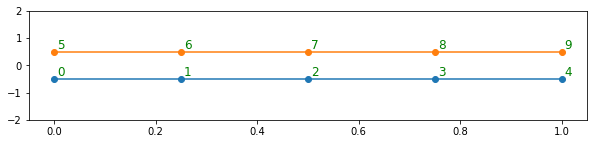

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,2))
plot_mesh_O_CI(ax, x_Ia,O_CI)

**Elementwise coordinate and index maps:** The mapping into the elementwise arranged node coordinates and degrees of freedom depends on the formulation of the finite element. In case of an implicitly layered cross section we can define general index mapping rearanging the globally defined arrays $x_Ia$ and $O_{CIa}$ into elementwise shape required by the integral expressions, i.e. $x_{Eia}$ and $O_{ECia}$. This mapping is done by defining an element node template $o_{aci}$ that specifies the maps the local index of a layer and node withn an element.  

In [40]:
E_map_ci = np.array([[[0,1],[0,1]],[[0,0],[1,1]]])
def get_E_xO(x_Ia, O_CI):
    ix_2ci = O_CI[0,:-1,None,None] + E_map_ci[0,:,:]
    ix_1ci = E_map_ci[1:,:,:]
    # elementwise array of degrees of freedom
    O_ECi = O_CI[ix_1ci, ix_2ci]
    # elementwise array of node coordinates shared for layers C
    x_Eia = x_Ia[ix_2ci[:,0,:]]
    return x_Eia, O_ECi

**Assembly of global matrix and vectors:** The stack of element matrices is directly passed to a `SysMtxAssembly` class that uses the sparse solvers based on the element node mapping. Displacement boundary conditions are inserted using the register_constraint method supplying the degree of freedom and the value. 

In [41]:
x1_Eia, O1_ECi = get_E_xO(x_Ia, O_CI)
# elemnetwise array of flattened DOFs
O1_Ei = O1_ECi.reshape(-1,n_Eo)
# total number of DOFs
n1_O = np.max(O1_Ei)+1
d_sig_Em, d_tau_Em = np.array([[[1]]]), np.array([[1]])
K1_Eop = get_K_Eop(
    get_Q1_EmCiaDjb(x1_Eia, xi_m, w_m), get_Q0_EmCiDj(x1_Eia, xi_m, w_m),
    d_sig_Em, d_tau_Em
)
K1_OP = SysMtxAssembly()
K1_OP.add_mtx_array(K1_Eop, O1_Ei)
K1_OP.register_constraint(0, 0)
#K1_OP.register_constraint(n1_O - 1, 0.1)
F_ext = np.zeros((n1_O,), np.float_)
F_ext[-1] = 1
K1_OP.apply_constraints(F_ext)
U1, _ = K1_OP.solve(F_ext)

**Show the displacement and strain profiles:**
To associate the displacements arranged in a flat vector let us apply the index map $ECi \rightarrow o$ stored in the array $o_{ECi}$ to get a three dimensional array
\begin{align}
u_{ECi} = U_{o}[o_{ECi}] \; \mathrm{where} \; o_{ECi}: ECi \rightarrow o
\end{align}
Let us use this mapping to obtain the primary field variable $u_1$ for further postprocessing

In [42]:
u1_ECi = U1[O1_ECi]

**plot_mesh_displ( ax, x_Eia, u_ECi ) :** function plotting the deformed configuration - definition in a hidden cell below 

In [43]:
def plot_mesh_disp(ax, x_Eia, u_ECi):
    xy_offset = (3, 3)
    fontsize=12
    ax.set_ylim((-2,2))
    x_Ei = x_Eia[...,0]
    u_CEi = np.einsum('ECi->CEi', u_ECi)
    for y, u_Ei in zip([-0.5,0.5], u_CEi):
        x_ = (x_Ei + u_Ei).flatten()
        ax.plot(x_, np.zeros_like(x_)+y, marker='o');

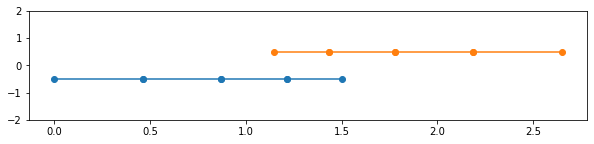

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,2))
plot_mesh_disp(ax, x1_Eia, u1_ECi)

To plot the slip at the correct positions the positions $x_{Ei0}$ are used as they are identical with the integration points:

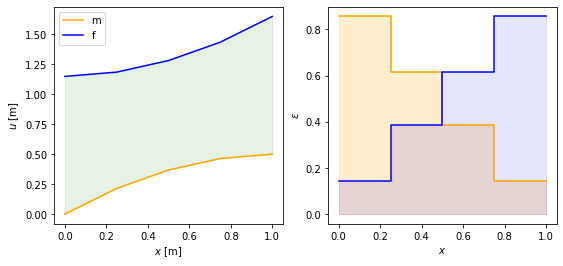

In [45]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 4))
plot_u_ECm(ax1, u1_ECi, x1_Eia)
plot_var_ECm(ax2, u1_ECi, x1_Eia, xi_m, get_var_ECm=get_eps_ECm, ylabel=r'$\varepsilon$')

# Material behavior

**Constitutive law:** The material behavior has been factored out from the previous derivation of the numerical model. In the verification example, a linear constitutive relation was assumed with the material stiffnesses $E_\mathrm{m}$ and $E_\mathrm{f}$ of the matrix and fiber, respectively, equal to 1. Also the bond stiffness $E_\mathrm{b} = 1$. In the next step we will combine linear elastic behavior of layers $\mathrm{m}$ and $\mathrm{f}$ with a nonlinear bond. 

**Layers:** For the layers, stress-strain relation is assumed as
i.e. \begin{align} 
\label{eq:constitutive}
{\sigma _{\rm{f}}} &= E_{\rm{f}}^{}\varepsilon_{\rm{f}}, \;\;
{\sigma _{\rm{m}}} = E_{\rm{m}}^{}\varepsilon_{\rm{m}},
\end{align}
in index form, this equation reads
\begin{align} 
\label{eq:indexed_constitutive}
\sigma_{Ca} &= D_C\varepsilon_{Ca}
\end{align}

In [46]:
E_m, E_f = 1, 1 # Unit Emodulus assumed
D_C = np.array([E_m, E_f], dtype=np.float_)

Thus, functions evaluating strains using this constitutive law in terms of the primary displacement variable over the whole spatial domain read 
\begin{align} 
\sigma_{ECma} &= D_C\varepsilon_{ECma} = D_C N_{im,a} u_{ECia}
\end{align}
The implementation will be used both within a nonlinear time-stepping algorithm and in the postprocessing later on.

In [47]:
get_sig_ECm = lambda u_ECi, x_Eia, xi_m: np.einsum(
    'C,ECm->ECm', D_C, get_eps_ECm(u_ECi, x_Eia, xi_m) )

In [48]:
get_d_sig_ECm = lambda u_ECi, x_Eia, xi_m: np.einsum(
    'C,ECm->ECm', D_C, np.ones_like(get_eps_ECm(u_ECi, x_Eia, xi_m)))

**Bond-slip law:** An example bond model is defined as a piecewise linear function exhibiting softening. The nonlinear algorithm requires the evaluation of $\mathrm{d}\tau/\mathrm{d}s$ which is delivered symbolically using the `diff` method. The function is defined by three data points 
$(\tau_1,s_1), (\tau_2,s_2), (\tau_3,s_3)$. 

In [49]:
s, tau_1, s_1, tau_2, s_2, tau_3, s_3 = sp.symbols(
    r's, tau_1, s_1, tau_2, s_2, tau_3, s_3 '
)
tau_s = sp.Piecewise(
    (tau_1/s_1 * s, s < s_1), 
    (tau_1 + (tau_2-tau_1)/(s_2-s_1)*(s-s_1), s <= s_2), 
    (tau_2 + (tau_3-tau_2)/(s_3-s_2)*(s-s_2), s > s_2)
)
d_tau_s = tau_s.diff(s)

The dictionary of values specifying the data points is defined as

In [50]:
bond_data = dict(tau_1=2, s_1=0.1, tau_2=0.5, s_2=0.4, tau_3=0.05, s_3=1.6)

To transform the symbolic representation of the function to a function callable with a an array of slip values evaluated in a single call let us use again the `sp.lambdify` generator

In [51]:
tau_s_ = sp.lambdify(s, tau_s.subs(bond_data), 'numpy' )
d_tau_s_ = sp.lambdify(s, d_tau_s.subs(bond_data), 'numpy' )

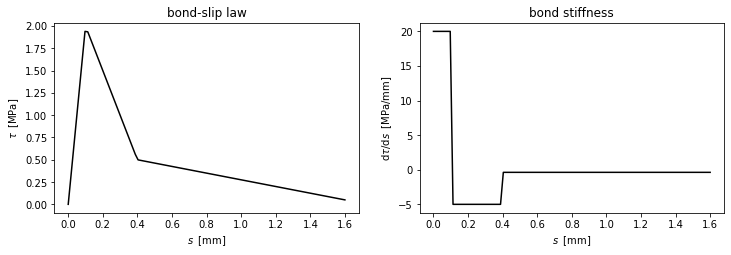

In [52]:
s_max = float(s_3.subs(bond_data))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3.5)) 
fig.subplots_adjust(hspace=0.5)
s_data = np.linspace(0, s_max, 100)
ax1.plot(s_data, tau_s_(s_data),color='black')
ax1.set_xlabel(r'$s\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$\tau\;\;\mathrm{[MPa]}$'); 
ax1.set_title('bond-slip law')
ax2.plot(s_data, d_tau_s_(s_data), color='black')
ax2.set_xlabel(r'$s\;\;\mathrm{[mm]}$'); ax2.set_ylabel(r'$\mathrm{d}\tau/\mathrm{d}s\;\;\mathrm{[MPa/mm]}$');
ax2.set_title('bond stiffness');

In [53]:
fig.savefig('fig_bond_slip_law.pdf')

Array based evaluation of the bond stress and stiffness directly in terms of the primary displacement field is then defined as
\begin{align} 
\tau_{mE} &= \tau( \zeta_C N_{mi} u_{mECi} )
\end{align}

In [54]:
get_tau_Em = lambda u_ECi, xi_m: tau_s_( get_s_Em(u_ECi, xi_m) )
get_d_tau_Em = lambda u_ECi, xi_m: d_tau_s_( get_s_Em(u_ECi, xi_m) )

With these functions, the material model is prepared to be plugged into the nonlinear time stepping loop. Note that the defined bond law does not distinguish the loading and unloading, as it is necessary to introduce a correct treatment of damage and plastic behavior driving the material nonlinearity. Thus, it can only be used for cases with monotonically increasing slip in every material point of the studied specimen. Still, for the explanatory purposes in focus here, such a definintion is completely sufficient and lets us even obtain some insight into the nonlinear behavior of a pullout specimen depending on the type of the bond-slip law.
Moreover, an extension of a material model to the more complex phenomenology does not affect the implementation of the nonlinear time stepping scheme.

**Material model as a class:** To make the developed model applicable to different types of materials and types of bond between the layer, it is convenient to bundle the methods 
calculating the stress and material stiffness, i.e. `get_sig_mEC`, `get_tau_mE`, `get_d_sig_mEC`, and `get_d_tau_mE` into a single object that can be passed as a parameter to a solution algorithm.

# Time-stepping algorithm

**Intialization of the system vectors and matrix:** The global vector of external forces $F^\mathrm{ext}$ is represented as a flat array. Individual loads may be simply assigned to a corresponding degree of freedom. For example, the first degree of freedom represents the matrix free end on the left. The last degree of freedom, i.e. $n_O$ represents the right free end of the fiber. 

The system matrix is instantiated using the `SysMtxAssembly` class that can register the constraints on selected degrees of freedom using the method `register_constraint`. A constraint is registered only once before starting the equilibrium iteration loop. Its value can be modified during the calculation.

The fundamental displacement is initialized to zero vector $U^{(n)}$.

**Incremental equilibrium iteration scheme:** The loop defines below runs the Newton-Raphson iteration controlled either by load or by displacement until the required level of accuracy $R_\mathrm{acc}$ is reached. 

In [55]:
def get_UF_t(w, x_Eia, O_ECi, n_t = 100):
    # elemnetwise array of flattened DOFs
    O_Ei = O_ECi.reshape(-1,n_Eo)
    # total number of DOFs
    n_O = int(np.max(O_Ei)+1)
    # Global vectors
    F_ext = np.zeros((n_O,), np.float_)
    F_O = np.zeros((n_O,), np.float_)
    U_k_O = np.zeros((n_O,), dtype=np.float_)
    # Setup the system matrix with displacement constraints
    K_OP = SysMtxAssembly()
#    K_OP.register_constraint(0, 0.0)
    K_OP.register_constraint(int(n_O/2)-1, 0.0)
    control = K_OP.register_constraint(n_O - 1, 0.0);
    # Time stepping parameters
    t_n1, t_max, t_step = 0, 1, 1/n_t
    # Iteration parameters
    k_max, R_acc = 1000, 1e-3
    # Record solutions
    U_t_list, F_t_list = [], []
    # Precalculated integration operators
    B1_EmCia = get_B1_EmCia(x_Eia, xi_m, w_m)
    B0_EmCi = get_B0_EmCi(x_Eia,xi_m, w_m)
    Q1_EmCiaDjb = get_Q1_EmCiaDjb(x_Eia, xi_m, w_m)
    Q0_EmCiDj = get_Q0_EmCiDj(x_Eia, xi_m, w_m)

    # Load increment loop
    while t_n1 < t_max:
        
        U_t_list.append(np.copy(U_k_O))
        F_t_list.append(F_O)
        
        control.u_a = w * t_step
        k = 0

        # Equilibrium iteration loop
        while k < k_max:

            # Transform the primary vector to field
            u_ECi = U_k_O[O_ECi]
            
            # Corrector: internal forces (stresses and shear flow)
            sig_ECm = get_sig_ECm(u_ECi, x_Eia, xi_m)
            tau_Em = get_tau_Em(u_ECi, xi_m)
            # Residuum
            F_Eo = get_F_Eo(B1_EmCia, B0_EmCi, sig_ECm, tau_Em)
            F_O = np.bincount(O_Ei.flatten(), weights=F_Eo.flatten())
            R_O = F_ext - F_O

            # Predictor: algorithmic system matrix
            d_sig_ECm = get_d_sig_ECm(u_ECi, x_Eia, xi_m)
            d_tau_Em = get_d_tau_Em(u_ECi, xi_m)
            # System matrix
            K_Eop = get_K_Eop(Q1_EmCiaDjb, Q0_EmCiDj, d_sig_ECm, d_tau_Em)
            K_OP.reset_mtx()
            K_OP.add_mtx_array(K_Eop, O_Ei)
            # Modify/add equations with kinematic constraints
            K_OP.apply_constraints(R_O)

            # Convergence criterion
            R_norm = np.linalg.norm(R_O)
            if R_norm < R_acc:
                # Convergence reached
                break 

            # Next iteration
            delta_U_O, _ = K_OP.solve()
            U_k_O += delta_U_O
            control.u_a = 0
            k += 1
        else:
            print('no convergence')
            break

        # Target time of the next load increment
        t_n1 += t_step

    print('time stepping finished at t = %g' % t_n1)
    U_t, F_t = np.array(U_t_list), np.array(F_t_list)
    return U_t, F_t

# Application examples

In [56]:
n_I = 10
x1_Ia = np.linspace(0,1,n_I).reshape(-1,1)
O1_CI = np.arange(2*n_I).reshape(2,-1)

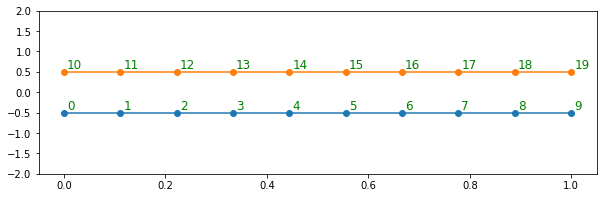

In [57]:
f, ax = plt.subplots(1,1,figsize=(10,3))
plot_mesh_O_CI(ax, x1_Ia, O1_CI)

In [107]:
x1_Eia, O1_ECi = get_E_xO(x1_Ia, O1_CI)
U_t, F_t = get_UF_t(1.03, x1_Eia, O1_ECi)

time stepping finished at t = 1


In [125]:
O1_ECi

array([[[ 0,  1],
        [10, 11]],

       [[ 1,  2],
        [11, 12]],

       [[ 2,  3],
        [12, 13]],

       [[ 3,  4],
        [13, 14]],

       [[ 4,  5],
        [14, 15]],

       [[ 5,  6],
        [15, 16]],

       [[ 6,  7],
        [16, 17]],

       [[ 7,  8],
        [17, 18]],

       [[ 8,  9],
        [18, 19]]])

In [116]:
U_10 = U_t[-1,-1]
F_10 = F_t[-1,-1]
u1_ECi = U_t[-1][O1_ECi]

**Plot displacements in final step:**

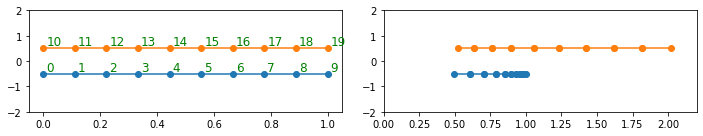

In [117]:
f_discr, (ax1, ax2) = plt.subplots(1,2, figsize=(10,2))
f_discr.tight_layout()
plot_mesh_O_CI(ax1, x1_Ia, O1_CI)
plot_mesh_disp( ax2, x1_Eia, u1_ECi )
ax2.set_xlim(0,2.2);

In [118]:
f_discr.savefig("fig_example_discretization.pdf")

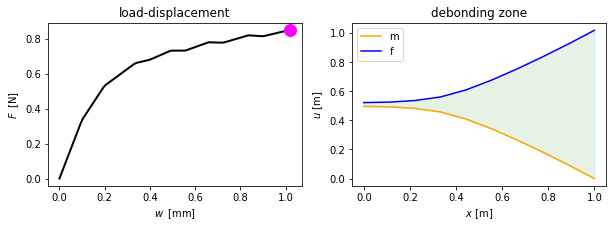

In [119]:
f_UF, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
ax1.plot(U_t[:,-1], F_t[:,-1], color='black', lw=2);
ax1.plot(U_10, F_10, color='magenta', marker='o', markersize=12);
ax1.set_xlabel(r'$w\;\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$F\;\;\mathrm{[N]}$');
plot_u_ECm(ax2, u1_ECi, x1_Eia)
ax1.set_title('load-displacement'); ax2.set_title('debonding zone');

In [120]:
f_UF.savefig('fig_UF_displ.pdf')

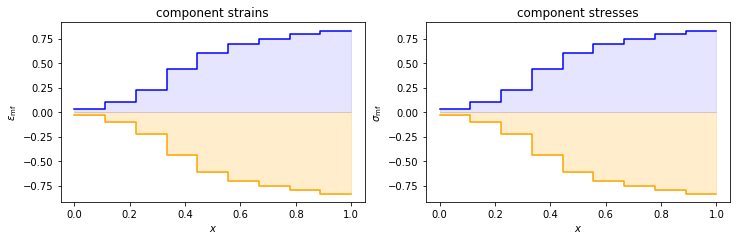

In [121]:
f_comps, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3.3))
plot_var_ECm(ax1, u1_ECi, x1_Eia, xi_m, get_var_ECm=get_eps_ECm, ylabel=r'$\varepsilon_\mathrm{mf}$')
plot_var_ECm(ax2, u1_ECi, x1_Eia, xi_m, get_var_ECm=get_sig_ECm, ylabel=r'$\sigma_\mathrm{mf}$')
ax1.set_title('component strains'); ax2.set_title('component stresses');

In [95]:
f_comps.savefig("fig_comps_profiles.pdf")

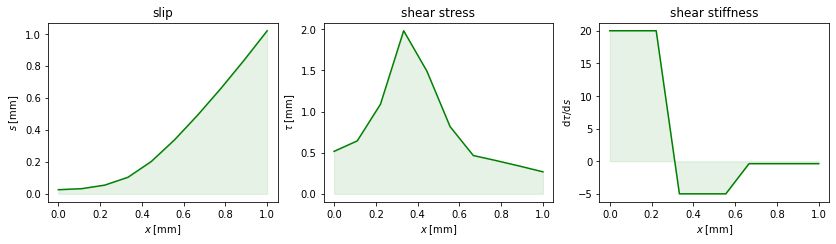

In [92]:
f_bond, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,3.3))
plot_filled(ax1, x1_Eia, get_s_Em(u1_ECi, xi_m).flatten(),color='green',alpha=0.1);
ax1.set_xlabel(r'$x\;\mathrm{[mm]}$'); ax1.set_ylabel(r'$s\;\mathrm{[mm]}$');
plot_filled(ax2, x1_Eia, get_tau_Em(u1_ECi, xi_m).flatten(),color='green',alpha=0.1);
ax2.set_xlabel(r'$x\;\mathrm{[mm]}$'); ax2.set_ylabel(r'$\tau\;\mathrm{[mm]}$');
plot_filled(ax3, x1_Eia, get_d_tau_Em(u1_ECi, xi_m).flatten(),color='green',alpha=0.1);
ax3.set_xlabel(r'$x\;\mathrm{[mm]}$'); ax3.set_ylabel(r'$\mathrm{d}\tau/\mathrm{d}s$');
ax1.set_title('slip'); ax2.set_title('shear stress'); ax3.set_title('shear stiffness');

In [93]:
f_bond.savefig("fig_bond_profiles.pdf")

# Pullout response animation

Set up the plotting figure with 2 x 2 diagrams showing the pullout curve, the evolution of strain and displacement of matrix and fiber, and the evolution of the shear stress along the bond zone mutual slip. To produce an animation the hidden cell below defines the plotting functions including the `init` and `animate` procedure are run during the animation.

In [82]:
%%capture

from matplotlib import animation, rc
from IPython.display import HTML
from traitlets import HasTraits, Any

# First set up the figure, the axis, and the plot element we want to animate
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2,2)
fig.set_size_inches(10.5, 7)

class PullOutAnimator(HasTraits):
    
    U_t = Any()
    F_t = Any()

    def init(self):
        '''Initialization function: plot the background of each frame
        '''
        U_t, F_t = self.U_t, self.F_t
        # Pullout curve
        axes_init(ax00, xlim=(0, U_t[-1,-1]*1.05), ylim=(0, F_t[-1,-1]*1.05),
                  xlabel='$w$ [mm]', ylabel='$P$ [N]', title='force  - displacement')
        self.FU_line, = ax00.plot([], [], color='black', lw=2)
        self.FU_marker, = ax00.plot([], [], color='magenta', marker='o', markersize=12)
        # Strain along the bond zone
        axes_init(ax01, xlim=(0, L_x), ylim=(-1.0, 1.0), 
                  xlabel='$x$ [mm]', ylabel=r'$\varepsilon$ [-]', title='strain')
        self.eps_m_line, = ax01.plot([], [], color='blue', lw=2, label=r'$\varepsilon_{\mathrm{m}}$')
        self.eps_f_line, = ax01.plot([], [], color='orange', lw=2, label=r'$\varepsilon_{\mathrm{f}}$')
        ax01.legend(loc=2)
        # Displacement along the bond zone
        axes_init(ax10, xlim=(0, L_x), ylim=(0.0, 1.3), 
                  xlabel='$x$ [mm]', ylabel='$u$ [mm]', title='')
        self.u_m_line, = ax10.plot([], [], color='blue', lw=2, label=r'$u_{\mathrm{m}}$')
        self.u_f_line, = ax10.plot([], [], color='orange', lw=2, label=r'$u_{\mathrm{f}}$')
        ax10.legend(loc=2)
        # Shear stress along the bond zone
        axes_init(ax11, xlim=(0, L_x), ylim=(0, 2.6), 
                  xlabel='$x$ [mm]', ylabel=r'$\tau$ [N]', title='')
        self.tau_line, = ax11.plot([], [], color='green', lw=2)

        self.FU_line.set_data(U_t[:,-1], F_t[:,-1])
        return (self.tau_line, self.eps_m_line, self.eps_f_line, 
                self.u_m_line, self.u_f_line, self.FU_line, self.FU_marker)

    def plot(self, i):
        '''Animation function called sequentially during the animation loop
        '''
        U_t, F_t = self.U_t, self.F_t
        U = U_t[i]
        self.FU_marker.set_data(U_t[i,-1], F_t[i,-1])
        x_Ei0 = x_Eia[:,:,0].flatten()

        u_ECi = U[O_ECi]
        self.u_m_line.set_data(x_Ei0, u_ECi[:,0,:].flatten())
        self.u_f_line.set_data(x_Ei0, u_ECi[:,1,:].flatten())
        ax10.collections.clear()
        ax10.fill_between(x_Ei0, u_ECi[:,0,:].flatten(), u_ECi[:,1,:].flatten(), color='green', alpha=0.2 )

        eps_ECm = get_eps_ECm(u_ECi, x_Eia, xi_m)
        self.eps_m_line.set_data(x_Ei0, eps_ECm[:,0,:].flatten())
        self.eps_f_line.set_data(x_Ei0, eps_ECm[:,1,:].flatten())
        ax01.collections.clear()
        ax01.fill_between(x_Ei0, 0, eps_ECm[:,0,:].flatten(), color='blue', alpha=0.1 )
        ax01.fill_between(x_Ei0, 0, eps_ECm[:,1,:].flatten(), color='orange', alpha=0.1 )

        tau_Em = get_tau_Em(u_ECi, xi_m).flatten()
        self.tau_line.set_data(x_Ei0, tau_Em)
        ax11.collections.clear()
        ax11.fill_between(x_Ei0, 0, tau_Em, color='green', alpha=0.1 )
        return (self.tau_line, self.eps_m_line,  self.eps_f_line, 
                self.u_m_line, self.u_f_line, self.FU_line, self.FU_marker)

    def html5_video(self):
        n_t = len(self.U_t)
        # call the animator. blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, self.plot, init_func=self.init,
                                       frames=n_t, interval=100, blit=True)
        return anim.to_html5_video()

**Animate the history of the pullout response recorded:**
The response values are stored in two arrays $U_t$ and $F_t$.
This example shows two elastic glued layers that debond from both sides. The bond law exhibits nonlinear softening. One layer is fixed at both ends the other one is pulled at one end and free at the other end. 

In [83]:
L_x = 1
n_I = 100
x_Ia = np.linspace(0,L_x,n_I).reshape(-1,1)
O_CI = np.arange(n_C*n_I).reshape(2,-1)
x_Eia, O_ECi = get_E_xO(x_Ia, O_CI)
U_t, F_t = get_UF_t(1.22, x_Eia, O_ECi,n_t=50)

time stepping finished at t = 1


In [84]:
anim = PullOutAnimator(U_t=U_t, F_t=F_t)
HTML(anim.html5_video())

# Alternative discretization generator

This section is being kept here as a possible generator. It might be useful when revising the grid generation for 2D and 3D problems. However, the template based grid generation allows for a flexbile definition of node and DOF mapping within an element, which is particularly useful for irregular FE definition, integration and general postprocessing. Generation of the three types of mapping (E->o, E->i, E->m and E->   

**Descritization parameters:** number of elements along the bond zone is denoted as $n_E$ 

In [85]:
n_E = 29 # number of discretization elements

**Grid generation:** is performed by regular subdivision of the length $L$ into $n_E$ number of elements. Nodal coordinates are obtained using the `mgrid` function delivering a sequence

In [86]:
def get_x_Ia( n_I, L_x ):
    x_grid = np.array(np.mgrid[0:L_x:complex(0, n_I), ])
    return np.einsum('a...->...a', x_grid).reshape(-1, 1)

In [73]:
def get_x_Eia( n_I, L_x ):
    I = np.arange(n_I)
    I_Ei = np.c_[I[:-1], I[1:]]
    x_Ia = get_x_Ia(n_I, L_x)
    return x_Ia[I_Ei]

**Derived dimensional parameters** include the number of elemental degrees of freedom and the global number of DOFs $n_o$.

The discretization is regular so that the standard grid generators available in `numpy` are sufficient to generate the discretization.
To uniquelly identify the nodes within the discretization, let us first enumerate them as $I = 1\ldots n_I$

**Index mapping between layers, nodes, direction and global DOFs:**
Nodal displacements $u_{CIa}$ represents the primary unknowns in the discretized problem.
Therefore, they need to be uniqely enumerated and addressable as global degrees of freedom $o$ of the form
\begin{align}
(C,I,a) \rightarrow o
\end{align}
In the considered case of a uniaxial discretization with $n_C$ layers we can define mapping as follows:
\begin{align}
 o_{CIa} &= n_a(n_I C + I) + a \; \; \mathrm{where}  \\ 
 C &= 0 \ldots n_C-1, \\ \; I & = 0 \ldots n_I-1, \\ a &= 0 \ldots n_a - 1
\end{align}
This index map can be constructed using the `numpy` sequence array generator `arange` for each dimension $C$, $I$ and $a$ to produce onedimensional index arrays and then broadcasting them into a three dimensional array $(C,I,a)$ using the `np.newaxis` generic index: 

In [74]:
def get_O_CIa(n_C, n_I, n_a):
    C = np.arange(n_C)[:,np.newaxis,np.newaxis]
    I = np.arange(n_I)[np.newaxis,:,np.newaxis] 
    a = np.arange(n_a)[np.newaxis,np.newaxis,:]
    return n_a * (n_I * C + I) + a

In [75]:
get_O_CI = lambda n_I: get_O_CIa(n_C,n_I,n_a)[...,-1]

Mapping of a local node $i$ within an element $E$ and layer $C$ to the degree of freedom $o$
\begin{align}
(E,C,i) \rightarrow O
\end{align}
is constructed using the global enumeration of nodes DOFs $o_{CIa}$. By following the local element enumeration pattern, i.e. slicing over the left nodes first and then over the right nodes delivers the desired global mapping. Note that this issue is specific to this particular type of grid and a more general generators of DOF maps can be constructed or imported from general meshes.

In [76]:
def get_O_ECi(n_I):
    O_CI = get_O_CI(n_I)
    return np.einsum('iCE->ECi',np.vstack([[O_CI[:, :-1], O_CI[:, 1:]]]))

Mapping of node $i$ within an element $E$ to a degree of freedom $o$. This array is used to assemble the global vector of internal forces $F^\mathrm{int}_o$ and the system matrix $K_{op}$.

In [77]:
get_O_Ei = lambda n_I: get_O_ECi(n_I).reshape(-1, n_Eo)

In [78]:
get_O_ECi(5), get_x_Eia(5,1);